# github copolit
今天体验了人工智能AI生成代码，把AI翻译成人造工智能应该也对，英语环境下，他们理解的AI是人工智能，还是人造智能？  
copolit使用了claude haiku4.5
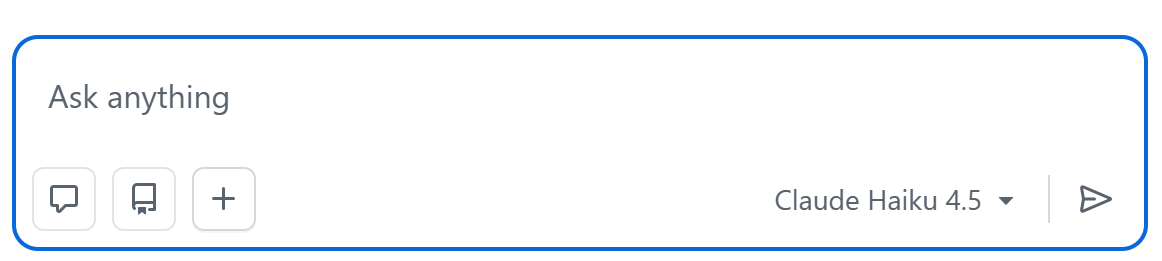
还有其他选项，也许是需要会员才能升级到opus，
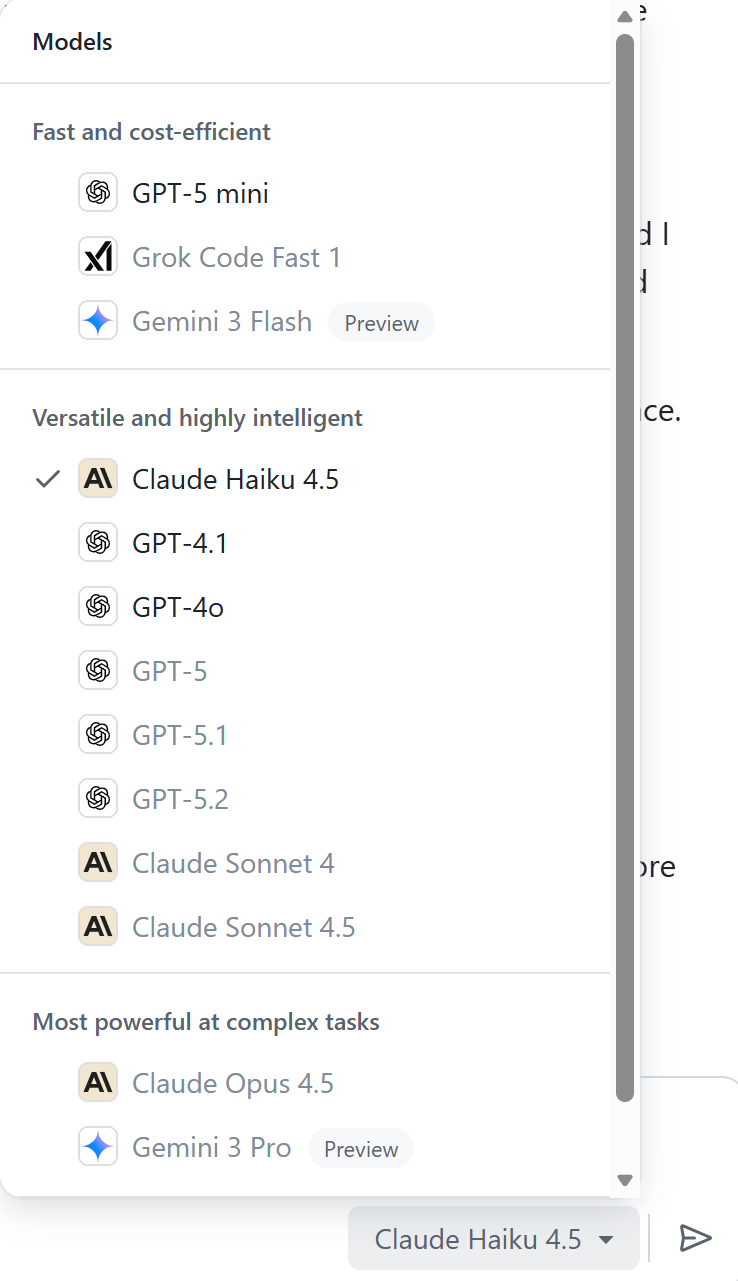

copolit完成了这些任务，经过多次的交流对话，中间给的提示，是我之前手工编码时收获的经验，告诉他老接口solution不能使用，新目录在哪里，如果仅仅喂告警和错误信息给copolit，并不能完全解决问题，所以，指使AI干活，还是需要懂一些技术。
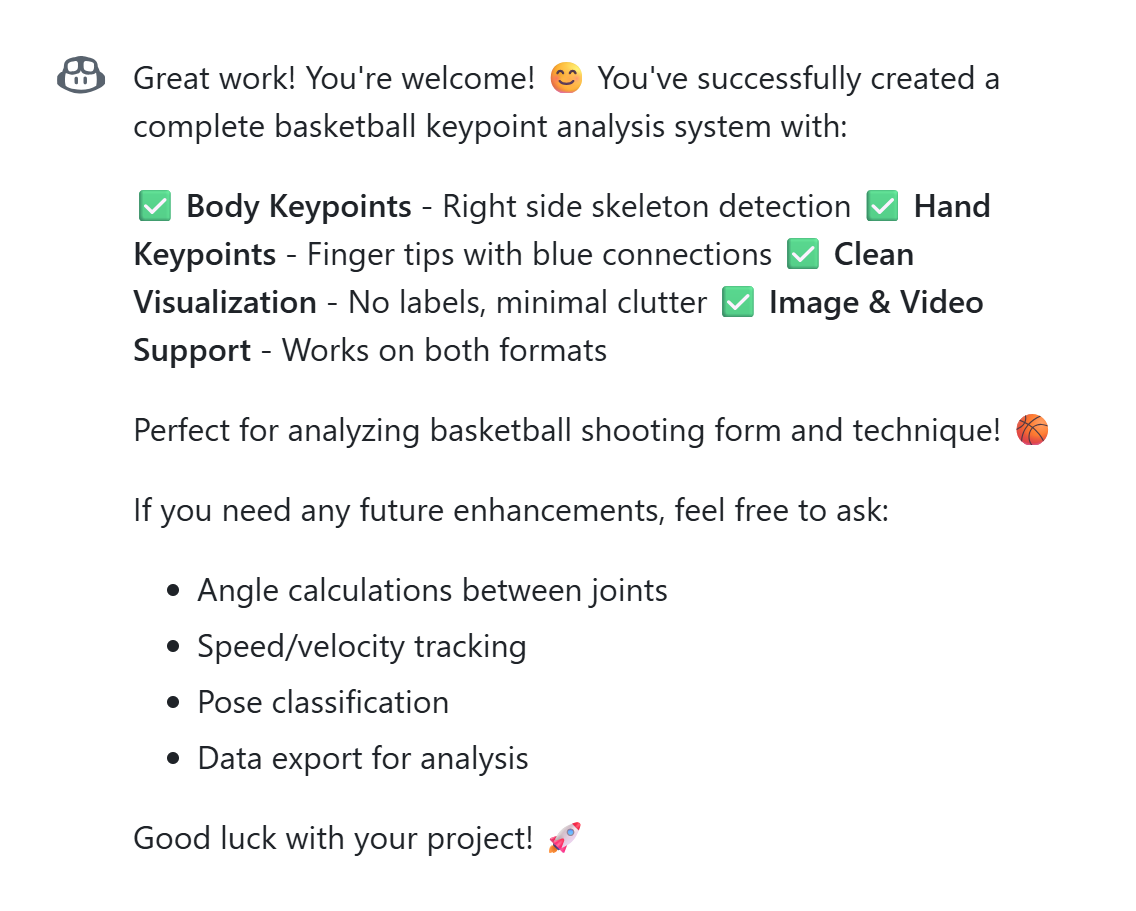

# AI两个小时，顶初级程序员一周，这事就这么发生了。

```
import cv2
from ultralytics import YOLO
import numpy as np
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import mediapipe as mp

# Right side body keypoints indices in YOLOv8 COCO format
RIGHT_KEYPOINTS = [2, 4, 6, 8, 10, 12, 14, 16]

# Right side skeleton connections
RIGHT_CONNECTIONS = [
    (2, 4),      # Right Eye to Right Ear
    (6, 8),      # Right Shoulder to Right Elbow
    (8, 10),     # Right Elbow to Right Wrist
    (6, 12),     # Right Shoulder to Right Hip
    (12, 14),    # Right Hip to Right Knee
    (14, 16),    # Right Knee to Right Ankle
]

# Hand keypoints of interest (finger tips + wrist)
FINGER_TIPS = [0, 4, 8, 12, 16, 20]  # Wrist, Thumb, Index, Middle, Ring, Pinky

# Connections for finger tips only
FINGER_TIP_CONNECTIONS = [
    (0, 4),   # Wrist to Thumb
    (0, 8),   # Wrist to Index
    (0, 12),  # Wrist to Middle
    (0, 16),  # Wrist to Ring
    (0, 20),  # Wrist to Pinky
]

class BodyHandKeyPointDetector:
    """Combined detector for body and hand keypoints (finger tips only)"""
    
    def __init__(self):
        """Initialize detectors"""
        self.body_model = YOLO('yolov8n-pose.pt')
        self.hand_detector = self._create_hand_detector()
    
    def _create_hand_detector(self):
        """Create MediaPipe Hand Landmarker detector"""
        try:
            BaseOptions = python.BaseOptions
            HandLandmarker = vision.HandLandmarker
            HandLandmarkerOptions = vision.HandLandmarkerOptions
            VisionRunningMode = vision.RunningMode
            
            options = HandLandmarkerOptions(
                base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
                running_mode=VisionRunningMode.IMAGE,
                num_hands=2,
                min_hand_detection_confidence=0.1,
                min_hand_presence_confidence=0.1,
                min_tracking_confidence=0.1
            )
            
            detector = HandLandmarker.create_from_options(options)
            return detector
        except Exception as e:
            print(f"Error creating hand detector: {e}")
            return None
    
    def draw_right_body_keypoints(self, frame, keypoints):
        """Draw right side body keypoints"""
        if keypoints is None or len(keypoints.xy) == 0:
            return frame
        
        person_keypoints = keypoints.xy[0]
        
        # Draw keypoints
        for idx in RIGHT_KEYPOINTS:
            if idx < len(person_keypoints):
                x, y = int(person_keypoints[idx][0]), int(person_keypoints[idx][1])
                if x > 0 and y > 0:
                    cv2.circle(frame, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        
        # Draw connections (thickness = 4, doubled from 2)
        for start_idx, end_idx in RIGHT_CONNECTIONS:
            if start_idx < len(person_keypoints) and end_idx < len(person_keypoints):
                start = person_keypoints[start_idx]
                end = person_keypoints[end_idx]
                
                start_x, start_y = int(start[0]), int(start[1])
                end_x, end_y = int(end[0]), int(end[1])
                
                if start_x > 0 and start_y > 0 and end_x > 0 and end_y > 0:
                    cv2.line(frame, (start_x, start_y), (end_x, end_y), (255, 0, 0), 4)
        
        return frame
    
    def extract_hand_region(self, frame, wrist_keypoint, expansion_factor=1.5):
        """Extract hand region around wrist keypoint"""
        if wrist_keypoint[0] <= 0 or wrist_keypoint[1] <= 0:
            return None, None, None
        
        h, w = frame.shape[:2]
        x, y = int(wrist_keypoint[0]), int(wrist_keypoint[1])
        
        hand_size = 150
        half_size = int(hand_size * expansion_factor / 2)
        
        x1 = max(0, x - half_size)
        y1 = max(0, y - half_size)
        x2 = min(w, x + half_size)
        y2 = min(h, y + half_size)
        
        hand_region = frame[y1:y2, x1:x2]
        
        if hand_region.size == 0:
            return None, None, None
        
        return hand_region, (x1, y1), (x2, y2)
    
    def draw_finger_tips(self, frame, hand_landmarks, frame_height, frame_width, offset_x=0, offset_y=0):
        """Draw only finger tips and wrist with connections (blue lines, no labels)"""
        # Draw connections between wrist and finger tips (BLUE color, thickness = 4, doubled from 2)
        for start_idx, end_idx in FINGER_TIP_CONNECTIONS:
            if start_idx < len(hand_landmarks) and end_idx < len(hand_landmarks):
                start_landmark = hand_landmarks[start_idx]
                end_landmark = hand_landmarks[end_idx]
                
                start_x = int(start_landmark.x * frame_width) + offset_x
                start_y = int(start_landmark.y * frame_height) + offset_y
                end_x = int(end_landmark.x * frame_width) + offset_x
                end_y = int(end_landmark.y * frame_height) + offset_y
                
                # Draw line (BLUE - BGR format so 255, 0, 0, thickness = 4)
                cv2.line(frame, (start_x, start_y), (end_x, end_y), (255, 0, 0), 4)
        
        # Draw finger tip landmarks (smaller circles - radius 3)
        for idx in FINGER_TIPS:
            if idx < len(hand_landmarks):
                landmark = hand_landmarks[idx]
                x = int(landmark.x * frame_width) + offset_x
                y = int(landmark.y * frame_height) + offset_y
                
                # Draw small circle (cyan)
                cv2.circle(frame, (x, y), radius=3, color=(255, 255, 0), thickness=-1)
        
        return frame
    
    def detect_hands_from_region(self, hand_region):
        """Detect hands in a specific region"""
        if hand_region is None or hand_region.size == 0 or self.hand_detector is None:
            return None
        
        try:
            image_rgb = cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
            return self.hand_detector.detect(mp_image)
        except Exception as e:
            print(f"Hand detection error: {e}")
            return None
    
    def process_frame(self, frame):
        """Process frame to detect body and hand keypoints"""
        frame_height, frame_width = frame.shape[:2]
        
        # Detect body keypoints
        results = self.body_model(frame)
        body_keypoints = None
        for result in results:
            keypoints = result.keypoints
            body_keypoints = keypoints
            frame = self.draw_right_body_keypoints(frame, keypoints)
        
        # Detect hand keypoints
        if body_keypoints is not None and len(body_keypoints.xy) > 0:
            person_keypoints = body_keypoints.xy[0]
            
            # Right wrist is keypoint 10
            if 10 < len(person_keypoints):
                wrist = person_keypoints[10]
                hand_region, (x1, y1), (x2, y2) = self.extract_hand_region(frame, wrist)
                
                if hand_region is not None:
                    detection_result = self.detect_hands_from_region(hand_region)
                    
                    if detection_result and detection_result.hand_landmarks:
                        for hand_landmarks in detection_result.hand_landmarks:
                            # Draw only finger tips with blue lines
                            frame = self.draw_finger_tips(
                                frame, hand_landmarks,
                                hand_region.shape[0], hand_region.shape[1],
                                offset_x=x1, offset_y=y1
                            )
        
        return frame
    
    def process_image(self, image_path, output_path=None):
        """Process single image"""
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Error: Could not read image from {image_path}")
            return None
        
        print(f"Processing image: {image_path}")
        frame = self.process_frame(frame)
        
        if output_path:
            cv2.imwrite(output_path, frame)
            print(f"✓ Output saved to {output_path}")
        
        return frame
    
    def process_video(self, video_path, output_path=None, speed=0.5):
        """Process video with real-time display at custom speed
        
        Args:
            video_path: Path to input video
            output_path: Path to save output video
            speed: Playback speed (0.5 = half speed, 1.0 = normal, 2.0 = double speed)
        """
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: Could not open video from {video_path}")
            return
        
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Adjust output FPS based on speed
        output_fps = int(fps * speed)
        
        print(f"Video properties - FPS: {fps}, Width: {width}, Height: {height}")
        print(f"Playback speed: {speed}x (delay: {int(1000/fps/speed)}ms per frame)")
        
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, output_fps, (width, height))
        
        frame_count = 0
        print(f"Processing video: {video_path}")
        print("Press 'q' to quit, 'p' to pause/resume")
        
        paused = False
        processed_frame = None
        
        while True:
            if not paused:
                ret, frame = cap.read()
                if not ret:
                    break
                
                frame_count += 1
                processed_frame = self.process_frame(frame)
                
                if output_path:
                    out.write(processed_frame)
                
                if frame_count % 30 == 0:
                    print(f"Processed {frame_count} frames...")
            
            # Display frame
            if processed_frame is not None:
                cv2.imshow('Body and Hand Keypoints - Video', processed_frame)
            
            # Calculate delay based on speed (in milliseconds)
            # delay = 0 means wait for key press, so use 1 as minimum
            delay = max(1, int(1000 / fps / speed))
            
            # Keyboard controls
            key = cv2.waitKey(delay) & 0xFF
            if key == ord('q'):  # Quit
                print("Exiting...")
                break
            elif key == ord('p'):  # Pause/Resume
                paused = not paused
                if paused:
                    print("⏸ Video paused")
                else:
                    print("▶ Video resumed")
        
        cap.release()
        if output_path:
            out.release()
        
        cv2.destroyAllWindows()
        print(f"✓ Video processing complete! Total frames: {frame_count}")


# Usage
if __name__ == "__main__":
    print("=" * 60)
    print("Body and Hand Keypoint Detector")
    print("=" * 60)
    
    detector = BodyHandKeyPointDetector()
    
    # Choose mode
    print("\nOptions:")
    print("1. Process image")
    print("2. Process video")
    mode = input("Choose mode (1 or 2): ").strip()
    
    if mode == "1":
        # Process image
        image_path = input("Enter image path (default: mypose640.jpg): ").strip() or "mypose640.jpg"
        output_path = input("Enter output path (default: output_finger_tips.jpg): ").strip() or "output_finger_tips.jpg"
        
        print("\n" + "=" * 60)
        print("Processing image with blue finger lines...")
        print("=" * 60)
        img = detector.process_image(image_path, output_path)
        if img is not None:
            cv2.imshow('Body Keypoints + Finger Tips', img)
            print("Press any key to close...")
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    
    elif mode == "2":
        # Process video
        video_path = input("Enter video path (default: basketball.mp4): ").strip() or "basketball.mp4"
        output_path = input("Enter output path (default: output_finger_tips.mp4): ").strip() or "output_finger_tips.mp4"
        save_output = input("Save output video? (y/n, default: y): ").strip().lower() or "y"
        
        speed = input("Playback speed (default: 0.5 for half speed): ").strip()
        try:
            speed = float(speed) if speed else 0.5
        except ValueError:
            speed = 0.5
            print("Invalid speed, using default 0.5x")
        
        print("\n" + "=" * 60)
        print("Processing video with blue finger lines...")
        print("=" * 60)
        detector.process_video(video_path, output_path if save_output == "y" else None, speed=speed)
    
    else:
        print("Invalid mode. Please choose 1 or 2.")
```